<a href="https://colab.research.google.com/github/bryonie/Spatio_HW/blob/master/Bryonie_Spatio_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup Google Drive for pulling in files


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"18DPGKwPOdUQMn2xsyZLI1B1VNGA0ALG1"})   
downloaded.GetContentFile('2046729_spatial.csv')
downloaded = drive.CreateFile({'id':"1WoYkI7EjCB-4b9_HmufNwyNbhjx_n7CO"})   
downloaded.GetContentFile('2046729_traj.csv') 
downloaded = drive.CreateFile({'id':"1IPs0suoPwl4HZZ8dnsNEA0ofyR5NTDcw"})   
downloaded.GetContentFile('CA_Counties_TIGER2016.shp') 
downloaded = drive.CreateFile({'id':"1dg5wM-rqqPAGWHNJlJiBFPdvUYf7a-C5"})   
downloaded.GetContentFile('CA_Counties_TIGER2016.dbf')
downloaded = drive.CreateFile({'id':"1eu6_XgzimKqO5EqqfrparchwclYpQVB5"})   
downloaded.GetContentFile('CA_Counties_TIGER2016.shx')
downloaded = drive.CreateFile({'id':"1f7qYlYRzmX1paCXT-19LPBxs0owydT8H"})   
downloaded.GetContentFile('CA_Counties_TIGER2016.sbx')
downloaded = drive.CreateFile({'id':"1P1sm-r0c2GSTpyNp3dSKQ1Cg5cIbh1FN"})   
downloaded.GetContentFile('CA_Counties_TIGER2016.sbn')

Imports and reading files

In [47]:
# pip install pyshp
# pip install geopandas
pip install pysal==2.0.0

     |████████████████████████████████| 25.0MB 1.5MB/s 
  Created wheel for pysal: filename=pysal-2.0.0-cp36-none-any.whl size=25231751 sha256=757facf4bb045598b2aa0cda5739274513a46bddbb4e4b56996a1a6ac342d877
  Stored in directory: /root/.cache/pip/wheels/ca/b9/69/49a64348ddb1feaf76b426c81c1db7275cfabacd8bf4ccd778
Successfully built pysal


In [52]:
import numpy as np
import pandas as pd
from matplotlib.dates import date2num, num2date
import datetime as datetime
import matplotlib .pyplot as plt
import shapefile as shp
import geopandas as gpd
from mpl_toolkits import mplot3d
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

spatial_file = '2046729_spatial.csv'
county_shape = 'CA_Counties_TIGER2016.shp'
county_dbf = 'CA_Counties_TIGER2016.dbf'
county_shx = 'CA_Counties_TIGER2016.shx'
county_sbx = 'CA_Counties_TIGER2016.sbx'
county_sbn = 'CA_Counties_TIGER2016.sbn'

spatial_data = pd.read_csv(spatial_file)

spatial_data.head()

Unnamed: 0  Unnamed: 0.1           name  ...   latitude   longitude  Virus X
0           0             0         Sierra  ...  36.985898 -119.232078        5
1           1             1     Sacramento  ...  38.573659 -121.487147      506
2           2             2  Santa Barbara  ...  34.423403 -119.704416      652
3           3             3      Calaveras  ...  38.231085 -120.619990        1
4           4             4        Ventura  ...  34.265900 -119.258366       28

[5 rows x 8 columns]

Normalizing Data (with comments)

In [5]:
normalized_dict = {
    "": ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'],
    "Unnamed: 0": [],
    "Unnamed: 0.1": [],
    "population": [],
    "latitude": [],
    "longitude": [],
    "Virus X": []
}

keys = list(normalized_dict.keys())
print(keys)

for key in keys:
  if(key != ''):
    normalized_dict[key].append(spatial_data[key].count())
    normalized_dict[key].append(spatial_data[key].mean())
    normalized_dict[key].append(spatial_data[key].std())
    normalized_dict[key].append(spatial_data[key].min())
    normalized_dict[key].append('25')
    normalized_dict[key].append('50')
    normalized_dict[key].append('75')
    normalized_dict[key].append(spatial_data[key].max())

# normalized_data = pd.DataFrame(normalized_dict)

normalized_data = spatial_data.describe()

normalized_data


['', 'Unnamed: 0', 'Unnamed: 0.1', 'population', 'latitude', 'longitude', 'Virus X']


Unnamed: 0  Unnamed: 0.1  ...   longitude      Virus X
count   58.000000     58.000000  ...   58.000000    58.000000
mean    28.500000     28.500000  ... -120.734224   406.224138
std     16.886879     16.886879  ...    1.886696  1391.077457
min      0.000000      0.000000  ... -123.965971     1.000000
25%     14.250000     14.250000  ... -122.102211     5.250000
50%     28.500000     28.500000  ... -120.905185    29.500000
75%     42.750000     42.750000  ... -119.781361   171.750000
max     57.000000     57.000000  ... -115.569962  9479.000000

[8 rows x 6 columns]

Plot time!

Question 2.1

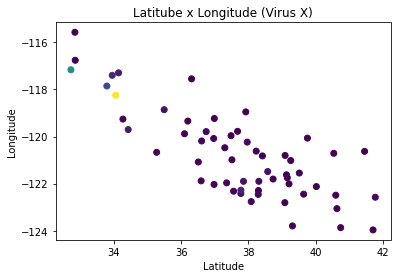

In [5]:
# Question 2.1
plt.scatter(
    spatial_data["latitude"],
    spatial_data["longitude"],
    c=spatial_data["Virus X"]
)
plt.title('Latitube x Longitude (Virus X)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

Question 2.2

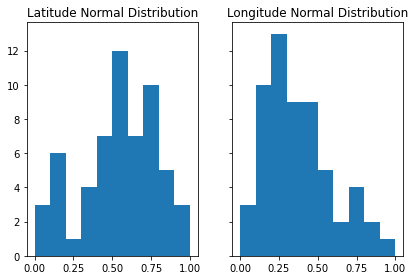

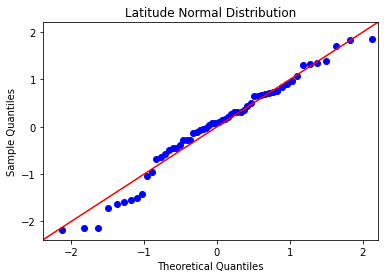

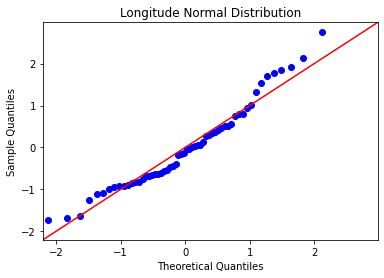

In [185]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

def Normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

latitude = Normalize(spatial_data["latitude"])
longitude = Normalize(spatial_data["longitude"])

# fig.suptitle("Latitude vs Longitude")
axs[0].set_title("Latitude Normal Distribution")
axs[0].hist(latitude, label="Latitude")
axs[1].set_title("Longitude Normal Distribution")
axs[1].hist(longitude, label="Longitude")


sm.qqplot(latitude,fit=True,line='45')
plt.title("Latitude Normal Distribution")
sm.qqplot(longitude,fit=True,line='45')
plt.title("Longitude Normal Distribution")
plt.show()



Question 2.3

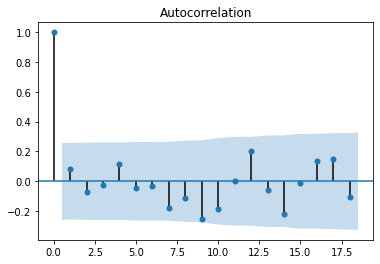

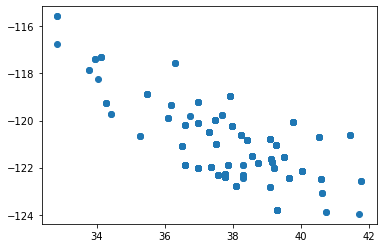

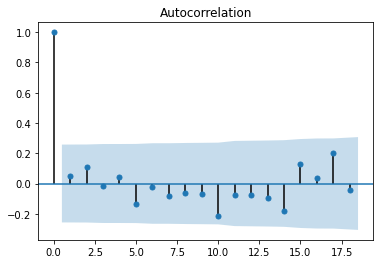

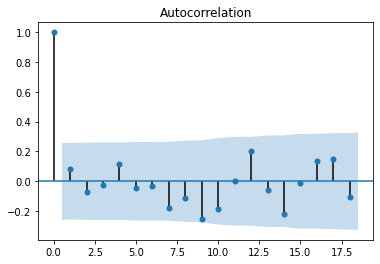

In [64]:
lag = 2
tol = 0.2

P = np.array(spatial_data[['latitude', 'longitude']])
P2 = np.array(spatial_data[['latitude', 'longitude', 'Virus X']])
# P[:,2]

pwdist = squareform(pdist(P))
pwdist2 = squareform(pdist(P2[:,:2]))

i,j = np.where((pwdist >= lag - tol) & (pwdist < lag + tol)) 
x,y = np.where((pwdist2 >= lag - tol) & (pwdist2 < lag + tol)) 

indicies = np.c_[i,j][np.where(j > i)]
indicies2 = np.c_[x,y][np.where(y > x)]
# plt.figure()

# print(P[indicies[:,1],0])

plt.scatter(
    [P[indicies[:,0],0],P[indicies[:,1],0]],
    [P[indicies[:,0],1],P[indicies[:,1],1]]
)
# plt.scatter(P2[indicies[:,1],0],P[indicies[:,1],1])
# print(P[indicies[:,0],1])

plot_acf(spatial_data['latitude'])
plot_acf(spatial_data['longitude'])
# plot_acf(P[indicies[:,1],0])
# plot_acf(P[indicies[:,1],1])
# plot_acf(P[:,1])


Question 2.4

Question 2.5

Question 2.6

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')


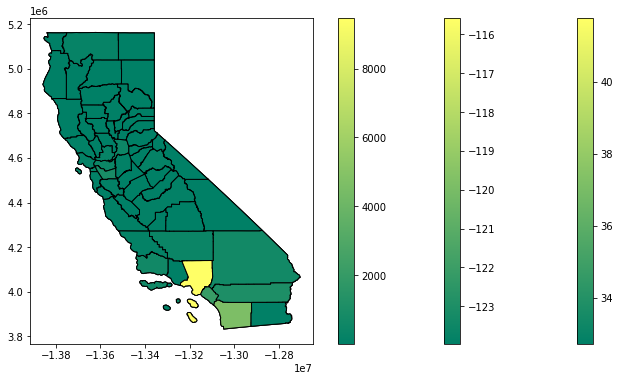

<Figure size 432x288 with 0 Axes>

In [57]:
cali = shp.Reader(county_shape)
fig, ax = plt.subplots(figsize=(14, 6))
# cali.shapeRecords()

plt.figure()
# for shape in cali.shapeRecords():
#     x = [i[0] for i in shape.shape.points[:]]
#     y = [i[1] for i in shape.shape.points[:]]
#     plt.plot(x,y)


geo_cali = gpd.read_file(county_shape)

print(geo_cali.columns)

# print(geo_cali["NAME"])
# for col in geo_cali.columns:
#   print(col)
#   print(geo_cali[col])

# for col in geo_cali.columns.drop('geometry'):
#   geo_cali.plot(column=col,categorical=True,legend=True,ax=ax, edgecolor='k')

geo_cali['latitude'] = spatial_data['latitude']
geo_cali['longitude'] = spatial_data['longitude']
geo_cali['virus'] = spatial_data['Virus X']

geo_cali.plot(column='latitude',cmap="summer",legend=True,ax=ax, edgecolor='k')
geo_cali.plot(column='longitude',cmap="summer",legend=True,ax=ax, edgecolor='k')
geo_cali.plot(column='virus',cmap="summer",legend=True,ax=ax, edgecolor='k')
# geo_cali.plot(column='NAME',categorical=True,legend=True,ax=ax, edgecolor='k')

plt.show()

Question 2.7

Global: 0.5082305953301478 0.001
Local: [0.002 0.275 0.015 0.331 0.163 0.001 0.338 0.416 0.002 0.084 0.414 0.358
 0.171 0.011 0.331 0.001 0.305 0.007 0.02  0.127 0.105 0.101 0.41  0.004
 0.495 0.123 0.229 0.134 0.005 0.125 0.071 0.001 0.024 0.041 0.114 0.015
 0.14  0.022 0.326 0.002 0.373 0.466 0.052 0.001 0.184 0.352 0.225 0.012
 0.072 0.051 0.327 0.047 0.001 0.466 0.097 0.441 0.001 0.344]


<Figure size 432x288 with 0 Axes>

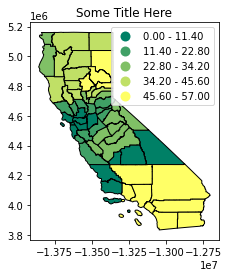

In [65]:
import pysal.model.spreg as sp
import pysal.lib as ps
import pysal.explore.esda as es
from pysal.explore.esda.moran import Moran_Local, Moran

county_weights = ps.weights.Rook.from_shapefile(county_shape)

county_weights.transform = 'r'
matrix, ids = county_weights.full()

county_virus = ps.weights.lag_spatial(county_weights,spatial_data['Virus X'].values)
county_virus_glob = Moran(county_virus,county_weights)
county_virus_loc = Moran_Local(county_virus,county_weights)

print("Global: {} {}".format(county_virus_glob.I,county_virus_glob.p_sim))
print("Local: {}".format(county_virus_loc.p_sim))

plt.figure()
geo_cali.assign(cl=county_virus_loc.Is).plot(column='cl',cmap="summer", scheme="QUANTILES", k=5, categorical=True, legend=True, edgecolor='k')
plt.title("Some Title Here")
plt.show()

Question 2.8

population    1.000000
Virus X       0.935327
Name: population, dtype: float64
Poulation/Virus X correlation: 0.9353273282290357
            population   Virus X
population    1.000000  0.935327
Virus X       0.935327  1.000000
Population: 0.021495213026965446
Virus X: -0.05830222943978724


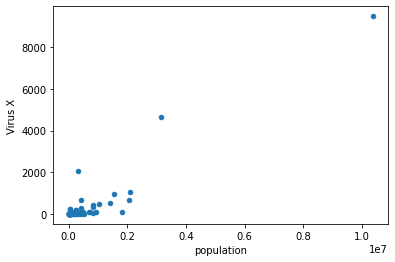

In [90]:
from itertools import combinations

spatial_data.plot.scatter(x="population", y="Virus X")

spatial_data_corr = pd.DataFrame(
    {
        "population":spatial_data["population"],
        "Virus X":spatial_data["Virus X"]
    }
)

spatial_data_corr = spatial_data_corr.corr()

print(spatial_data_corr["population"][:5])

print("Poulation/Virus X correlation: {}".format(spatial_data["population"].corr(spatial_data["Virus X"])))

print(spatial_data[["population","Virus X"]].corr())

print("Population: {}".format(spatial_data["population"].autocorr()))
print("Virus X: {}".format(spatial_data["Virus X"].autocorr()))

# geo_cali.assign(population_corr=spatial_data_corr["population"])
# geo_cali.assign(virus_x_corr=spatial_data_corr["Virus X"])
# geo_cali["population_corr"] = spatial_data_corr["population"]
# geo_cali["virus_x_corr"] = spatial_data_corr["Virus X"]
# print(geo_cali.columns)
# geo_cali.plot(column='population_corr',cmap="summer", scheme="QUANTILES", k=5, categorical=True, legend=True, edgecolor='k')
# geo_cali.plot(column='virus_x_corr',cmap="summer", scheme="QUANTILES", k=5, categorical=True, legend=True, edgecolor='k')